## 1. Loading Data 

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings

import importlib
import yfDataLoader as yfdl
importlib.reload(yfdl)


warnings.filterwarnings("ignore")

In [18]:
# Our prediction target is the percentge increaase in the value of the stock at close
# we define our target variable as an increase larger than 0.5% (so that it’s wortwile to make a purchase)
# df['change'] = np.log(df['close']) - np.log(df['open'])
# update the dataframe with the change column 
#get stockprice from last 5 years 
data = yfdl.get_historical_prices('TSLA','2010-06-29','2024-08-26')
data.info()


data['Change']=((data['Close'] - data['Open']) / data['Open'])*100
# data['CloseINV']=data['Open']*(1 + (data['Change'] /100))

# print(data[["Open","Close","Change","CloseINV"]])

import pandas_ta as ta


# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563 entries, 0 to 3562
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3563 non-null   datetime64[ns]
 1   Open       3563 non-null   float64       
 2   High       3563 non-null   float64       
 3   Low        3563 non-null   float64       
 4   Close      3563 non-null   float64       
 5   Adj Close  3563 non-null   float64       
 6   Volume     3563 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 195.0 KB


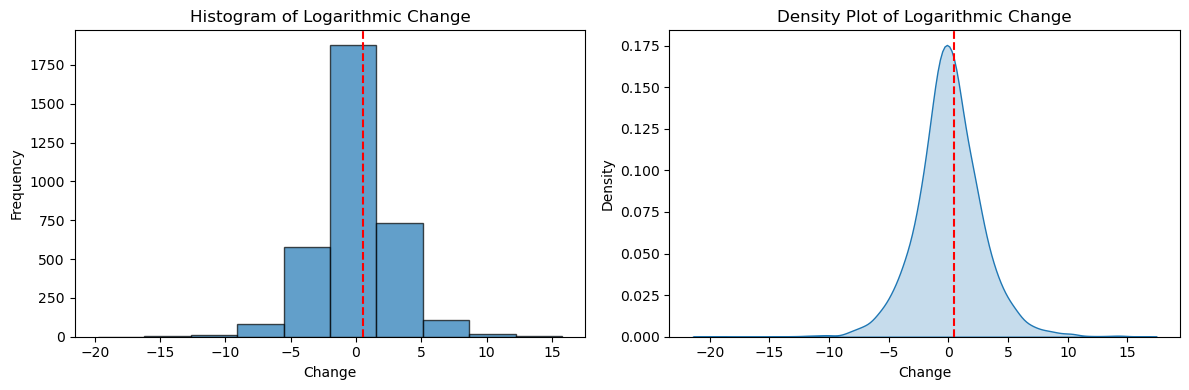

In [19]:
import seaborn as sns
plt.ion()  # Turn on interactive mode
# Plot Change distribution 
plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(data['Change'], bins=10, edgecolor='k', alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--', label='x=0.05')  # Vertical line at x=0.5
plt.title('Histogram of Logarithmic Change')
plt.xlabel('Change')
plt.ylabel('Frequency')

# Density Plot using Seaborn
plt.subplot(1, 2, 2)
sns.kdeplot(data['Change'], shade=True)
plt.axvline(x=0.5, color='r', linestyle='--', label='x=0.05')  # Vertical line at x=0.5
plt.title('Density Plot of Logarithmic Change')
plt.xlabel('Change')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Observing the Distribution of ‘change’ 
This means all the observations to the right side of the red line would be our ‘success’ scenarios.

## 2. Spliting Data as Train and Validation

In [22]:
# Scale the dataset for to center all datapoints around the origin  

from sklearn.preprocessing import MinMaxScaler
import time
scaler = MinMaxScaler(feature_range = (0,1))


print(data.head(5))

# data[['Close_Scaled']]=scaler.fit_transform(data[['Change']])
data_set_scaled = scaler.fit_transform(data)
print(data_set_scaled)


# data['Date'] = pd.to_datetime(data['Date'])
# # Convert Date to Unix Timestamp (seconds since epoch)
# data['Timestamp'] = data['Date'].view('int64') / 10**9  # Convert to seconds

# print(data.head())

   index      Open      High       Low  Adj Close    Change        RSI  \
0    149  1.603333  1.608000  1.566667   1.606667  0.207945  39.355771   
1    150  1.620667  1.648667  1.569333   1.594000 -1.645434  38.612865   
2    151  1.610667  1.612000  1.578000   1.596000 -0.910619  38.808267   
3    152  1.588000  1.593333  1.543333   1.575333 -0.797674  37.487123   
4    153  1.562667  1.578000  1.548000   1.564000  0.085303  36.752037   

       EMAF      EMAM      EMAS    Target  TargetClass  TargetNextClose  
0  1.704250  1.697052  1.576578 -0.026667            0         1.594000  
1  1.693750  1.695011  1.576809 -0.014667            0         1.596000  
2  1.684441  1.693051  1.577063 -0.012667            0         1.575333  
3  1.674049  1.690720  1.577040  0.001333            1         1.564000  
4  1.663568  1.688210  1.576867 -0.012667            0         1.538000  
[[0.00000000e+00 3.69088611e-04 2.98618671e-04 ... 5.98930110e-01
  0.00000000e+00 3.39441881e-04]
 [2.93083236

In [23]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
timesteps = 30
print(data_set_scaled.shape[0])
for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(timesteps, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-timesteps:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[timesteps:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

3413
[[[0.00000000e+00 3.69088611e-04 2.98618671e-04 ... 5.61760333e-01
   2.85809739e-01 4.42785534e-04]
  [2.93083236e-04 4.11364765e-04 3.97082970e-04 ... 5.09602124e-01
   2.76045167e-01 4.13764891e-04]
  [5.86166471e-04 3.86975615e-04 3.08303495e-04 ... 5.30281460e-01
   2.78613488e-01 3.88034562e-04]
  ...
  [7.91324736e-03 4.32500517e-04 3.58343098e-04 ... 5.06395659e-01
   4.05577855e-01 1.66485252e-04]
  [8.20633060e-03 3.36570617e-04 3.19603514e-04 ... 5.81868040e-01
   4.11407189e-01 1.66586738e-04]
  [8.49941383e-03 3.31692845e-04 2.79248735e-04 ... 4.88565235e-01
   3.39455998e-01 1.52288811e-04]]

 [[2.93083236e-04 4.11364765e-04 3.97082970e-04 ... 5.09602124e-01
   2.76045167e-01 4.13764891e-04]
  [5.86166471e-04 3.86975615e-04 3.08303495e-04 ... 5.30281460e-01
   2.78613488e-01 3.88034562e-04]
  [8.79249707e-04 3.31692845e-04 2.63106303e-04 ... 5.33459981e-01
   2.61248701e-01 3.59314670e-04]
  ...
  [8.20633060e-03 3.36570617e-04 3.19603514e-04 ... 5.81868040e-01
   4.

In [73]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Change,CloseINV
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,25.736833,1.592667
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,-7.599808,1.588667
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,-12.160018,1.464000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,-16.521720,1.280000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,-19.449981,1.074000


In [24]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2706
(2706, 30, 8)
(677, 30, 8)
(2706, 1)
(677, 1)
[[1.61560869e-04]
 [1.59930518e-04]
 [1.84409420e-04]
 ...
 [8.15502353e-01]
 [8.26297568e-01]
 [7.84993416e-01]]


In [ ]:
from sklearn.model_selection import train_test_split

# Set the features . 
# X = data['Timestamp']  
# X = data[['Timestamp','Open', 'Volume']].values  # Features
# # Set the target .
# # y = data[['Close']].values

# length_data = len(data)     # rows that data has
# split_ratio = 0.7           # %70 train + %30 validation
# length_train = round(length_data * split_ratio)  
# length_validation = length_data - length_train
# print("Data length :", length_data)
# print("Train data length :", length_train)
# print("Validation data lenth :", length_validation)

# train_data = data[:length_train].iloc[:,:2] 

# train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
# train_data

# timesteps = 1
# X_sequences = []
# y_sequences = []

# for i in range(len(X) - timesteps):
#     X_sequences.append(X[i:i + timesteps])
#     y_sequences.append(y[i + timesteps])

# X_sequences = np.array(X_sequences)
# y_sequences = np.array(y_sequences)

# print(X_sequences.shape)  # Should be (number_of_sequences, timesteps, number_of_features)
# print(y_sequences.shape)  # Should be (number_of_sequences,)

# # Split data into training and testing and set the test_size = 30%
# X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.30, random_state=42)


# # # Randomly shuffle the data and split it
# # train = data.sample(frac=0.7, random_state=42)  # 70% of the data
# # test = data.drop(train.index)  # The remaining 30%

# # print("70% Bucket:\n", train)
# # print("30% Bucket:\n", test)


## 3.Create the RNN model 

In [25]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

# Initialize the RNN model
model = Sequential()
print(X_train.shape[1])
# Adding the RNN layers
model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, activation='tanh'))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics = ["mean_absolute_error"])

# Display model summary
model.summary()

30


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 30, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,101 (51.18 KB)

 Trainable params: 13,101 (51.18 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from keras.callbacks import EarlyStopping
# Monitor Loss Parmeter and stop the model training 

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,               # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Fit the model with EarlyStopping callback
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping], # Add EarlyStopping callback
    verbose=1
)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 92s 198ms/step - loss: 0.3321 - mean_absolute_error: 0.4558 - val_loss: 0.2218 - val_mean_absolute_error: 0.4609
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.1671 - mean_absolute_error: 0.3248 - val_loss: 0.0653 - val_mean_absolute_error: 0.2321
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.0774 - mean_absolute_error: 0.2224 - val_loss: 0.0929 - val_mean_absolute_error: 0.2777
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0398 - mean_absolute_error: 0.1576 - val_loss: 0.1130 - val_mean_absolute_error: 0.3122
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.0283 - mean_absolute_error: 0.1329 - val_loss: 0.0379 - val_mean_absolute_error: 0.1613
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 0.0213 - mean_absolute_error: 0.1150 - val_loss: 0.0446 - val_mean_absolute_error: 0.1801
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.0164 - mean_absolute_error: 0.0998 -

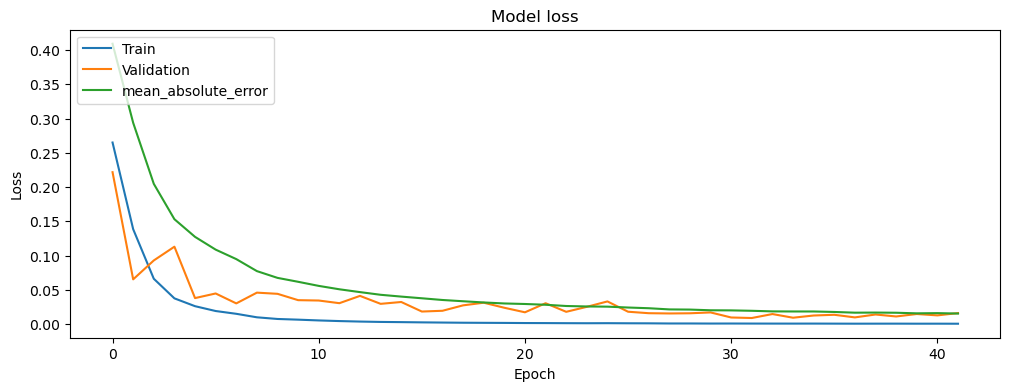

In [27]:
#Plot the Training and validtion loss 
plt.figure(figsize=(12, 4))
plt.ion()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['accuracy'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Model Loss', 'Validation',"mean_absolute_error"], loc='upper left')
plt.show()

In [28]:
#get model predictions 
y_pred = model.predict(X_test)  # predictions
#y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
# y_pred_inv = scaler.inverse_transform(y_pred)
# y_train_inv= scaler.inverse_transform(y_train)

print(y_pred)
print(y_test)


# y_train_inv = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
# print(y_train_inv.shape)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step
[[0.6592561 ]
 [0.6522347 ]
 [0.6450997 ]
 [0.64267087]
 [0.6428519 ]
 [0.6388011 ]
 [0.6395982 ]
 [0.6379774 ]
 [0.63948524]
 [0.6493658 ]
 [0.6544428 ]
 [0.6639121 ]
 [0.6681665 ]
 [0.66206694]
 [0.6606832 ]
 [0.6692561 ]
 [0.670804  ]
 [0.67506176]
 [0.6661363 ]
 [0.6621603 ]
 [0.65521944]
 [0.65342003]
 [0.6621799 ]
 [0.66283333]
 [0.665291  ]
 [0.6570645 ]
 [0.65501654]
 [0.6513373 ]
 [0.64988   ]
 [0.64212495]
 [0.6382314 ]
 [0.64062774]
 [0.62946904]
 [0.6228928 ]
 [0.6242849 ]
 [0.6288819 ]
 [0.6319812 ]
 [0.63226634]
 [0.62932765]
 [0.6301574 ]
 [0.62937224]
 [0.6318446 ]
 [0.6303933 ]
 [0.63049114]
 [0.6264249 ]
 [0.6264902 ]
 [0.63017946]
 [0.62506974]
 [0.6271947 ]
 [0.6171107 ]
 [0.60643786]
 [0.59546447]
 [0.5926957 ]
 [0.59948176]
 [0.60702366]
 [0.6191767 ]
 [0.6097474 ]
 [0.6127605 ]
 [0.6068243 ]
 [0.6012315 ]
 [0.60717386]
 [0.6082329 ]
 [0.60594374]
 [0.6029242 ]
 [0.5910564 ]
 [0.5958508 ]
 [0.6016435 ]
 [0.6116097 ]
 [0.621

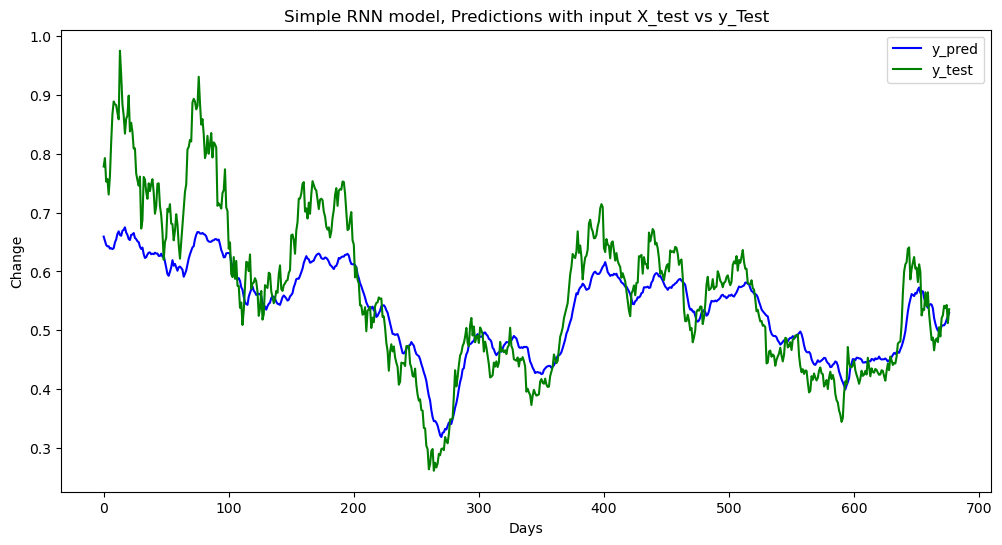

In [36]:
# visualisation
plt.figure(figsize = (12,6))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_test, color = "g", label = "y_test")
plt.xlabel("Days")
plt.ylabel("Change")
plt.title("Simple RNN model, Predictions with input X_test vs y_Test")
plt.legend()
plt.show()


In [37]:
#get model predictions 
y_pred_train = model.predict(X_train)  # predictions
#y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
# y_pred_inv = scaler.inverse_transform(y_pred)
# y_train_inv= scaler.inverse_transform(y_train)

print(y_pred_train)
print(y_train)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
[[-0.00659053]
 [-0.00709774]
 [-0.00668382]
 ...
 [ 0.65214556]
 [ 0.6588096 ]
 [ 0.65707636]]
[[1.61560869e-04]
 [1.59930518e-04]
 [1.84409420e-04]
 ...
 [8.15502353e-01]
 [8.26297568e-01]
 [7.84993416e-01]]


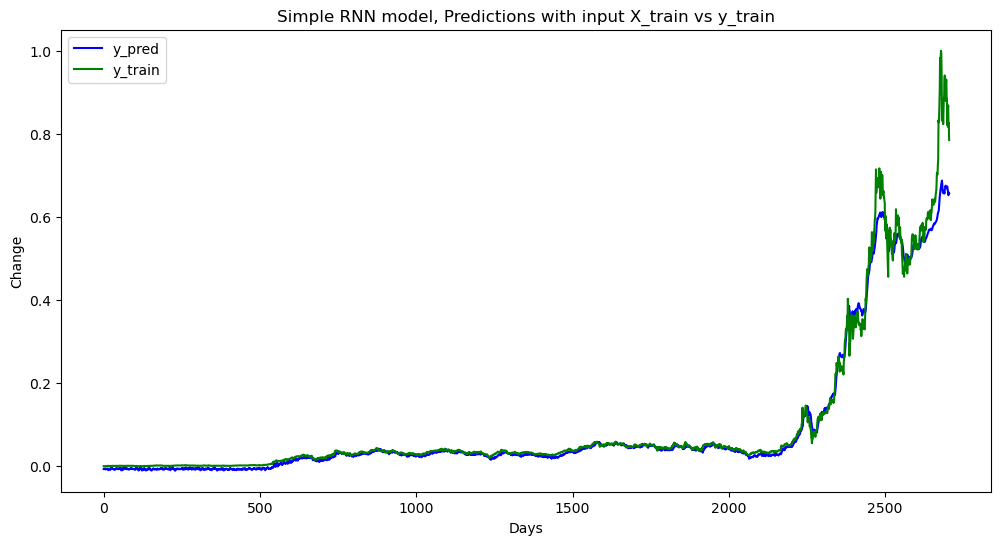

In [38]:
# visualisation
plt.figure(figsize = (12,6))
plt.plot(y_pred_train, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Change")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [41]:
#using LSTM Model 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(timesteps, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
lstm_hist = model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 6.7167e-05 - val_loss: 0.0022
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 6.6570e-05 - val_loss: 0.0080
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 6.4068e-05 - val_loss: 0.0054
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 6.2234e-05 - val_loss: 0.0028
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 5.6934e-05 - val_loss: 0.0025
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 4.0048e-05 - val_loss: 0.0020
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 5.2604e-05 - val_loss: 0.0020
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 4.3134e-05 - val_loss: 0.0087
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.4421e-05 - val_loss: 0.0067
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 5.0674e-05 - val_loss: 0.00

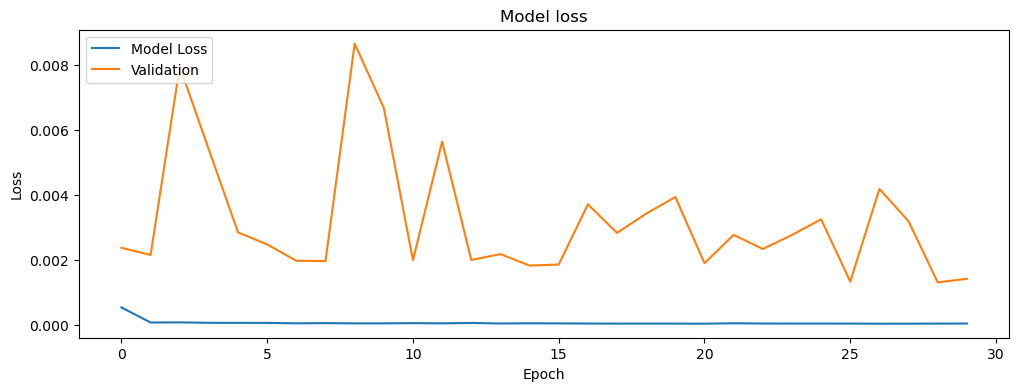

In [43]:
#Plot the Training and validtion loss 
plt.figure(figsize=(12, 4))
plt.ion()
plt.plot(lstm_hist.history['loss'])
plt.plot(lstm_hist.history['val_loss'])
# plt.plot(history.history['accuracy'])
# plt.plot(lstm_hist.history['mean_absolute_error'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Model Loss', 'Validation'], loc='upper left')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
[[0.7800605 ]
 [0.75069964]
 [0.7421972 ]
 [0.75394815]
 [0.73183155]
 [0.7313321 ]
 [0.7085058 ]
 [0.72999865]
 [0.78203416]
 [0.81697214]
 [0.8348486 ]
 [0.82606554]
 [0.81784797]
 [0.8079815 ]
 [0.80151254]
 [0.8966978 ]
 [0.86977077]
 [0.82674205]
 [0.8006599 ]
 [0.7860918 ]
 [0.8029198 ]
 [0.81541127]
 [0.84341115]
 [0.79886943]
 [0.7979005 ]
 [0.79232836]
 [0.77267176]
 [0.7741594 ]
 [0.7410383 ]
 [0.718638  ]
 [0.7222278 ]
 [0.73874223]
 [0.6750342 ]
 [0.6710413 ]
 [0.73432964]
 [0.7339659 ]
 [0.7125808 ]
 [0.7028203 ]
 [0.71732086]
 [0.7126075 ]
 [0.71591944]
 [0.72489923]
 [0.7087986 ]
 [0.6779354 ]
 [0.68742836]
 [0.7204782 ]
 [0.7211036 ]
 [0.6904103 ]
 [0.6719885 ]
 [0.6501686 ]
 [0.6190445 ]
 [0.63546693]
 [0.6449974 ]
 [0.6858866 ]
 [0.68384945]
 [0.6850229 ]
 [0.6610124 ]
 [0.65629315]
 [0.6413686 ]
 [0.652238  ]
 [0.67689085]
 [0.6617067 ]
 [0.6352093 ]
 [0.61317945]
 [0.6339443 ]
 [0.6637322 ]
 [0.6841135 ]
 [0.7042891 ]
 [0.7165

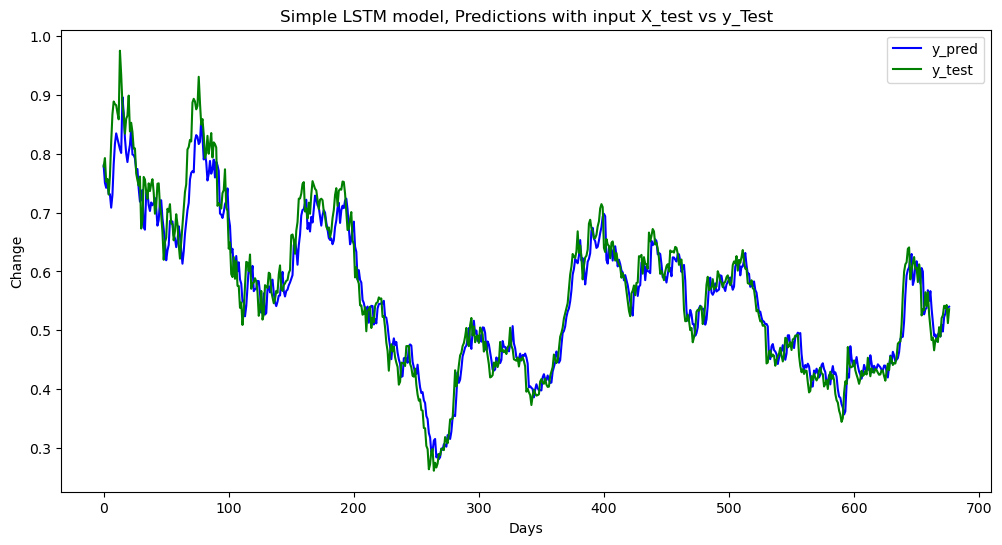

In [45]:
y_pred_lstm = model.predict(X_test)  # predictions
#y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
# y_pred_inv = scaler.inverse_transform(y_pred)
# y_train_inv= scaler.inverse_transform(y_train)

print(y_pred_lstm)
print(y_test)

plt.figure(figsize = (12,6))
plt.plot(y_pred_lstm, color = "b", label = "y_pred" )
plt.plot(y_test, color = "g", label = "y_test")
plt.xlabel("Days")
plt.ylabel("Change")
plt.title("Simple LSTM model, Predictions with input X_test vs y_Test")
plt.legend()
plt.show()